In [17]:
import pandas as pd
import os
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
def load_all_data(directory_path):
    '''Load data from all files in the specified folder and combine them into one dataset'''
    # Create an empty list to store all dataframes
    dataframes = []
    
    # Iterate through all files in the specified folder
    for file in os.listdir(directory_path):
        if file.endswith('.csv'):
            file_path = os.path.join(directory_path, file)
            try:
                df = pd.read_csv(file_path)
                dataframes.append(df)
            except Exception as e:
                print(f"Failed to load file {file}: {e}")
    
    # Combine all dataframes into one
    combined_df = pd.concat(dataframes, ignore_index=True)
    return combined_df

In [19]:
def visualize_missing_data(dataframe):
    '''Create a visualization of missing values'''
    plt.figure(figsize=(15, 8))
    msno.matrix(dataframe, sparkline=True, color=(0, 1, 0))
    plt.show()

In [20]:
def data_types_summary(dataframe):
    '''Print information about data types in each column'''
    print(dataframe.dtypes)

In [21]:
def missing_values_summary(dataframe):
    '''Calculate the count and percentage of missing values in each column'''
    missing_summary = dataframe.isnull().sum().to_frame(name='Missing Values')
    missing_summary['Percentage'] = (missing_summary['Missing Values'] / len(dataframe)) * 100
    print(missing_summary)


In [22]:
def visualize_correlation(dataframe):
    '''Create a heatmap to visualize the correlation between numerical columns'''
    # Select only numerical columns for correlation
    numeric_df = dataframe.select_dtypes(include=['number'])
    # Create a heatmap to visualize the correlation between numerical columns
    plt.figure(figsize=(15, 8))
    sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
    plt.title('Correlation between Numerical Columns')
    plt.show()


In [23]:
def show_unique_values(dataframe):
    '''Print unique values for each text column, excluding columns named 'id'''
    text_columns = dataframe.select_dtypes(include='object')  # Select only text columns (type 'object')
    for column in text_columns.columns:
        if column.lower() == 'id':  # Skip the ID column
            continue
        unique_values = text_columns[column].unique()  # Get unique values of the column
        unique_values_str = ', '.join(map(str, unique_values))  # Convert unique values to a string
        print(f"{column} - {unique_values_str}")


In [24]:
def analyze_id_column(dataframe):
    '''Analyze the 'id' column for duplicate values'''
    id_column = dataframe['id']
    if id_column.is_unique:
        print("No duplicates found.")
    else:
        duplicate_count = id_column.duplicated().sum()
        print(f"Duplicates found: {duplicate_count}")


**Аналіз якості даних в Дата Сеті**


**Data Quality Analysis in the Dataset**

In [25]:
# Path to the folder with files
directory_path = r'.\raw_data'

In [26]:
# Load all data
all_data_df = load_all_data(directory_path)

<Figure size 1500x800 with 0 Axes>

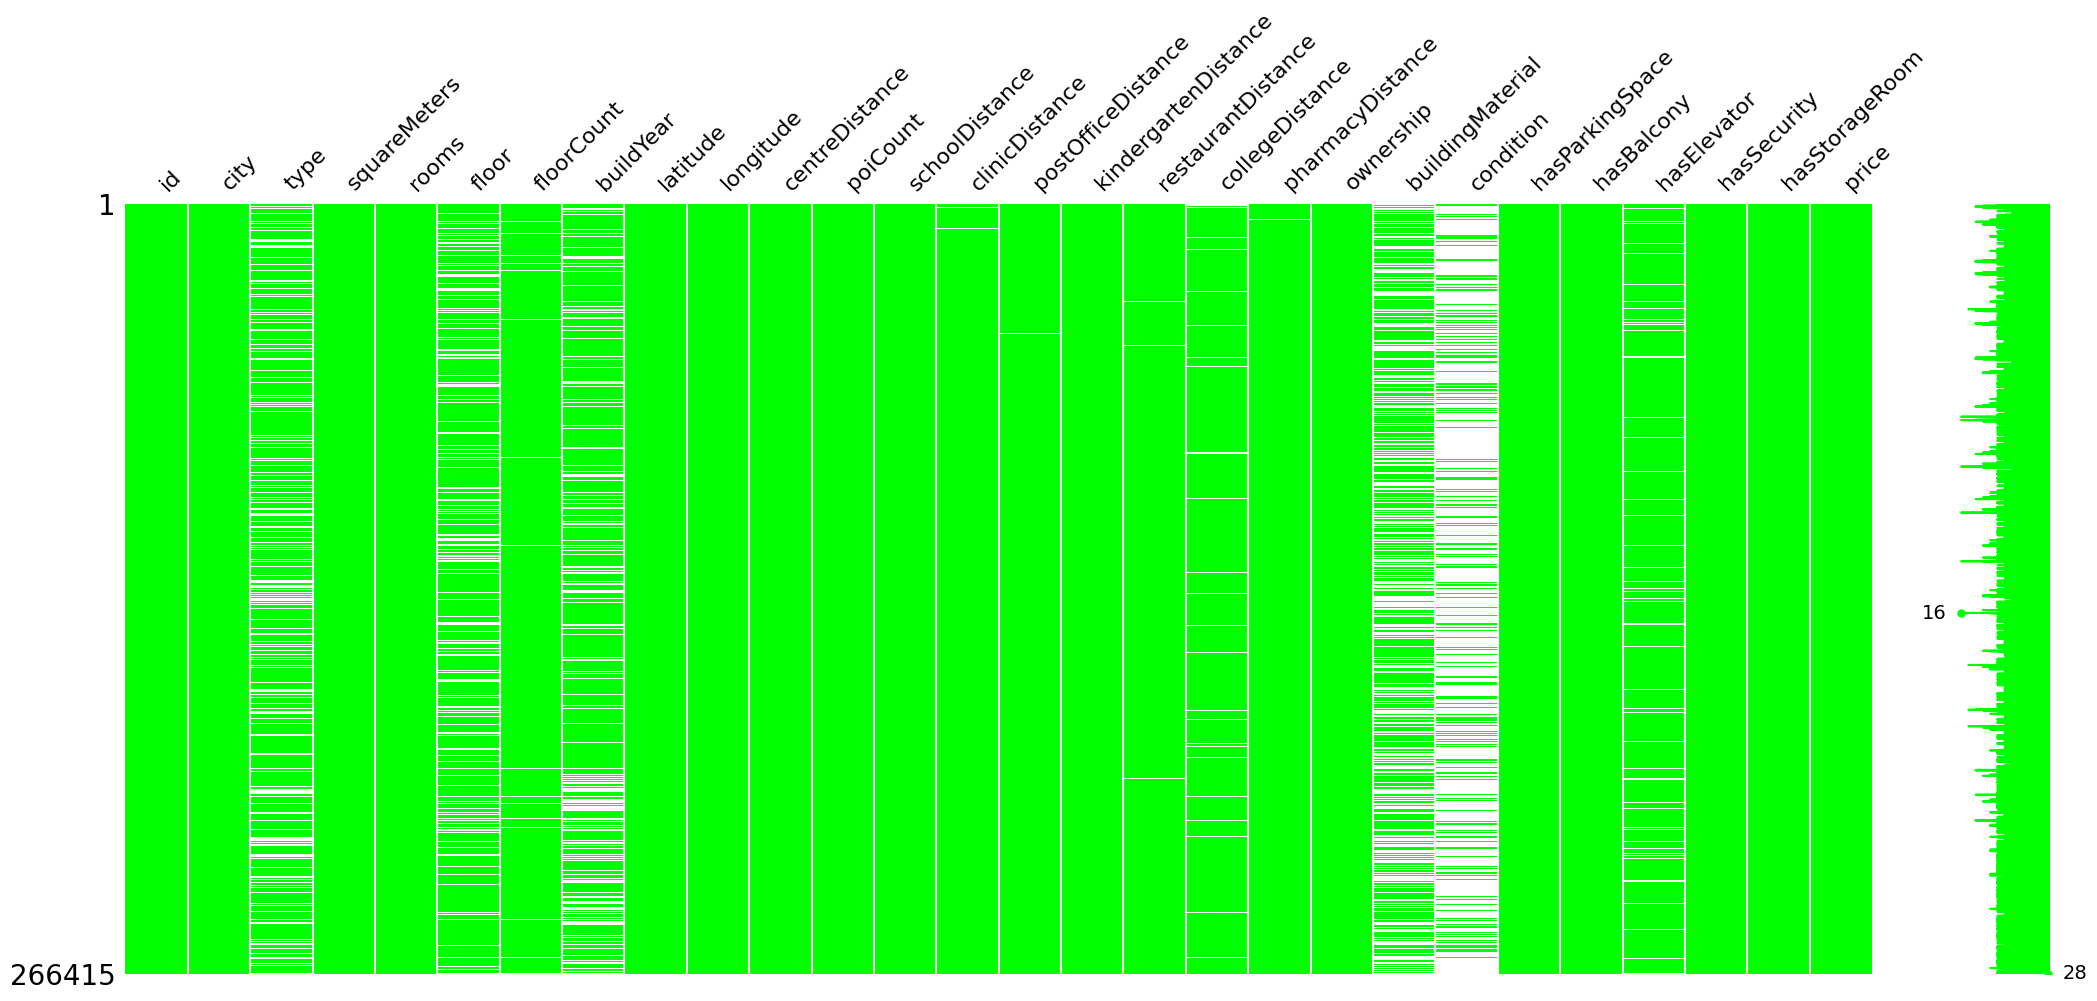

In [27]:
# Create a visualization of missing values
visualize_missing_data(all_data_df)

1. **Початковий візуальний аналіз**.
За допомогю візуального відображення всього масиву даних, ми можемо проаналізувати якість Дата Сету з точки зоку заповненості даними. Бачимо що наповненість виглядає досить не погано, але є певні які потрібно проаналізувати більш глибше, та прийняти рішення по їх нормалізації. Наприклад, найбільш проблемний показником є condition, в якому присутньо багато пустих рядків, також потребують уваги більшої уваги buildingMaterial type floor buildTear. Тому потрібно вивчити дані детальніше. Для початку підрахуємо кількість пустих даних по стовпцям, щоб бачити конкретну ситуацію по кожному стовпцю, та мати більше даних для рішення, як їх обробляти в подальшому

  EN:
1. **Initial Visual Analysis**.
Using a visual representation of the entire dataset, we can analyze the dataset quality in terms of data completeness. It seems that the completeness is quite good, but there are certain aspects that need deeper analysis and a decision on normalization. For example, the most problematic indicator is "condition", which has many missing rows. Other columns that require more attention are "buildingMaterial", "type", "floor", and "buildYear". Therefore, we need to examine the data more thoroughly. To start, we will count the number of missing values in each column to better understand the specific situation for each column and have more information to decide on their further processing.

In [28]:
# Call the function to count missing values
missing_values_summary(all_data_df)

                      Missing Values  Percentage
id                                 0    0.000000
city                               0    0.000000
type                           59023   22.154533
squareMeters                       0    0.000000
rooms                              0    0.000000
floor                          43207   16.217931
floorCount                      3762    1.412083
buildYear                      51898   19.480134
latitude                           0    0.000000
longitude                          0    0.000000
centreDistance                     0    0.000000
poiCount                           0    0.000000
schoolDistance                   183    0.068690
clinicDistance                   778    0.292026
postOfficeDistance               274    0.102847
kindergartenDistance             250    0.093839
restaurantDistance               633    0.237599
collegeDistance                 6310    2.368485
pharmacyDistance                 357    0.134001
ownership           

2. **Перегляд кількості пустих даних більш детальніше**:

Після підрахунку пустих значень, ми можемо поділити наявні дані на 3 категорії 
- **Високий відсоток пропусків (> 30%)**:
    - `buildingMaterial` (39.93% пропусків).
    - `condition` (74.31% пропусків).
    
    Дії:
    
    - Стовпець `condition` має дуже велику кількість пропусків. Можливо, варто було б видалити цей стовпець.
    Але я піду іншим шляхом, оскільки інформація про стан квартири має досить високу вагу при аналітиці нерухомості , як і продажу так і оренди. Тому я використаю інший підхід: condition має 2 категорії low та premium. Тобто квартири середнього сегменту або не подані в вибірці , або не мають відповідного позначення. Для збагачення даних в стовпці condition, я проаналізую максимальну та мінімальну ціну для для low та premium сегменту квартир. Та провірю чи ціна на квартиру з відсутнім значенням входить в окіл мін-макс ціни однієї з цих категорій.Якщо так додам вибрану кагорію, якщо ні присвою категорію серднього сегменту.
    
    - Для `buildingMaterial`, спробуємо заповнити пропуски модою (найпоширеніше значення), оскільки матеріал будівлі зазвичай є схожим для типових будинків у певному регіоні.

  2. **Середній відсоток пропусків (10-30%)**:
    - `type` (22.15% пропусків).
    - `buildYear` (19.48% пропусків).
    - `floor` (16.22% пропусків).
        
        Дії:
        - Для `type` заповнимо пропуски модою, оскільки тип об'єкта (наприклад, квартира чи дім) є досить загальною категорією, яка не потребує точних числових оцінок.
        - `buildYear`: можна заповнити середнім або медіанним значенням в залежності від міста.
        - `floor`: можемо заповнити пропуски залежно від `floorCount`. Наприклад, якщо `floorCount` має значення, заповнимо `floor` на основі середнього поверху для будинків із такою ж кількістю поверхів.

  3. **Низький відсоток пропусків (< 10%)**:
    - `floorCount` (1.41% пропусків).
    - Інші стовпці з пропусками: `schoolDistance`, `clinicDistance`, `postOfficeDistance`, `kindergartenDistance`, `restaurantDistance`, `collegeDistance`, `pharmacyDistance`, `hasElevator`.
        
        Дії:
        - **`floorCount`**: заповнимо середнім значенням, оскільки різниця в кількох поверхах зазвичай не є критичною.
        - **Відстані до об'єктів (`schoolDistance`, `clinicDistance` тощо)**: можемо заповнити пропуски середнім значенням у межах міста, оскільки ці змінні можуть суттєво відрізнятися в різних регіонах, але краще поглянемо на кореляцію різних показників, і проаналізуємо чи можемо використати більш точний підхід
        - **`hasElevator`**: заповнимо пропуски залежно від `floorCount`. Зазвичай якщо `floorCount` більше 5 поверхів, можемо припустити, що ліфт наявний і заповнити значення як `yes`.



  EN:
2. **Detailed Review of Missing Data**:

After counting the missing values, we can categorize the data into three groups:

- **High Percentage of Missing Values (> 30%)**:
  - `buildingMaterial` (39.93% missing).
  - `condition` (74.31% missing).

  Actions:

  - The `condition` column has a very high percentage of missing values. It might be worth deleting this column. However, I will take a different approach since information about the condition of an apartment is highly significant in real estate analytics, both for sales and rentals. I will use another approach: the `condition` column has two categories, "low" and "premium". This means that mid-segment apartments are either not present in the dataset or do not have an appropriate label. To enrich the data in the `condition` column, I will analyze the maximum and minimum prices for both the low and premium segments and check if the price of an apartment with missing values falls within the min-max range of one of these categories. If so, I will assign the appropriate category; otherwise, I will assign a mid-segment category.

  - For `buildingMaterial`, I will try to fill the missing values with the mode (the most common value), as the building material is often similar for typical buildings in a specific region.

- **Medium Percentage of Missing Values (10-30%)**:
  - `type` (22.15% missing).
  - `buildYear` (19.48% missing).
  - `floor` (16.22% missing).

  Actions:

  - For `type`, I will fill the missing values with the mode, as the type of property (e.g., apartment or house) is a fairly general category that does not require precise numerical evaluation.
  - `buildYear`: I can fill the missing values with the average or median value, depending on the city.
  - `floor`: I can fill the missing values based on `floorCount`. For instance, if `floorCount` is known, I will fill `floor` with the average floor for buildings with the same number of floors.

- **Low Percentage of Missing Values (< 10%)**:
  - `floorCount` (1.41% missing).
  - Other columns with missing values: `schoolDistance`, `clinicDistance`, `postOfficeDistance`, `kindergartenDistance`, `restaurantDistance`, `collegeDistance`, `pharmacyDistance`, `hasElevator`.

  Actions:

  - **`floorCount`**: I will fill the missing values with the average value, as a difference of a few floors is usually not critical.
  - **Distances to objects (`schoolDistance`, `clinicDistance`, etc.)**: I can fill the missing values with the average value within the city, as these variables can vary significantly in different regions, but it is better to look at correlations between different indicators and analyze whether a more precise approach can be used.
  - **`hasElevator`**: I will fill the missing values based on `floorCount`. Typically, if `floorCount` is greater than 5 floors, we can assume there is an elevator and fill the value as `yes`.

In [29]:
# Call the function to display data types
data_types_summary(all_data_df)

id                       object
city                     object
type                     object
squareMeters            float64
rooms                   float64
floor                   float64
floorCount              float64
buildYear               float64
latitude                float64
longitude               float64
centreDistance          float64
poiCount                float64
schoolDistance          float64
clinicDistance          float64
postOfficeDistance      float64
kindergartenDistance    float64
restaurantDistance      float64
collegeDistance         float64
pharmacyDistance        float64
ownership                object
buildingMaterial         object
condition                object
hasParkingSpace          object
hasBalcony               object
hasElevator              object
hasSecurity              object
hasStorageRoom           object
price                     int64
dtype: object


3. **Оцінка типів даних**:
    - Для того щоб більш точно працювати з даними виведоми список типів даних для кожного показника, щоб зрозуміти, які з них числові та в подальшому створити візуаліацію кореляції між ними, щоб більш наочно та глибоко побачити можливі взаємозв'язки та за допомогою них збагатити наш дата сет


  EN:  
 3. **Data Type Evaluation**:
  - To work more precisely with the data, we will output a list of data types for each feature to understand which ones are numerical. This will allow us to create a correlation visualization between them, helping to more clearly and deeply see potential relationships and use them to enrich our dataset.

4. **Категоріальні змінні (`object` type)**:
    - Для змінних, які є категоріальними (`ownership`, `buildingMaterial`, `condition`, `hasParkingSpace`, `hasBalcony`, `hasSecurity`, `hasStorageRoom`), рекомендується заповнювати пропуски модою.

EN:

4. **Categorical Variables (`object` type)**:
   - For variables that are categorical (`ownership`, `buildingMaterial`, `condition`, `hasParkingSpace`, `hasBalcony`, `hasSecurity`, `hasStorageRoom`), it is recommended to fill the missing values with the mode.

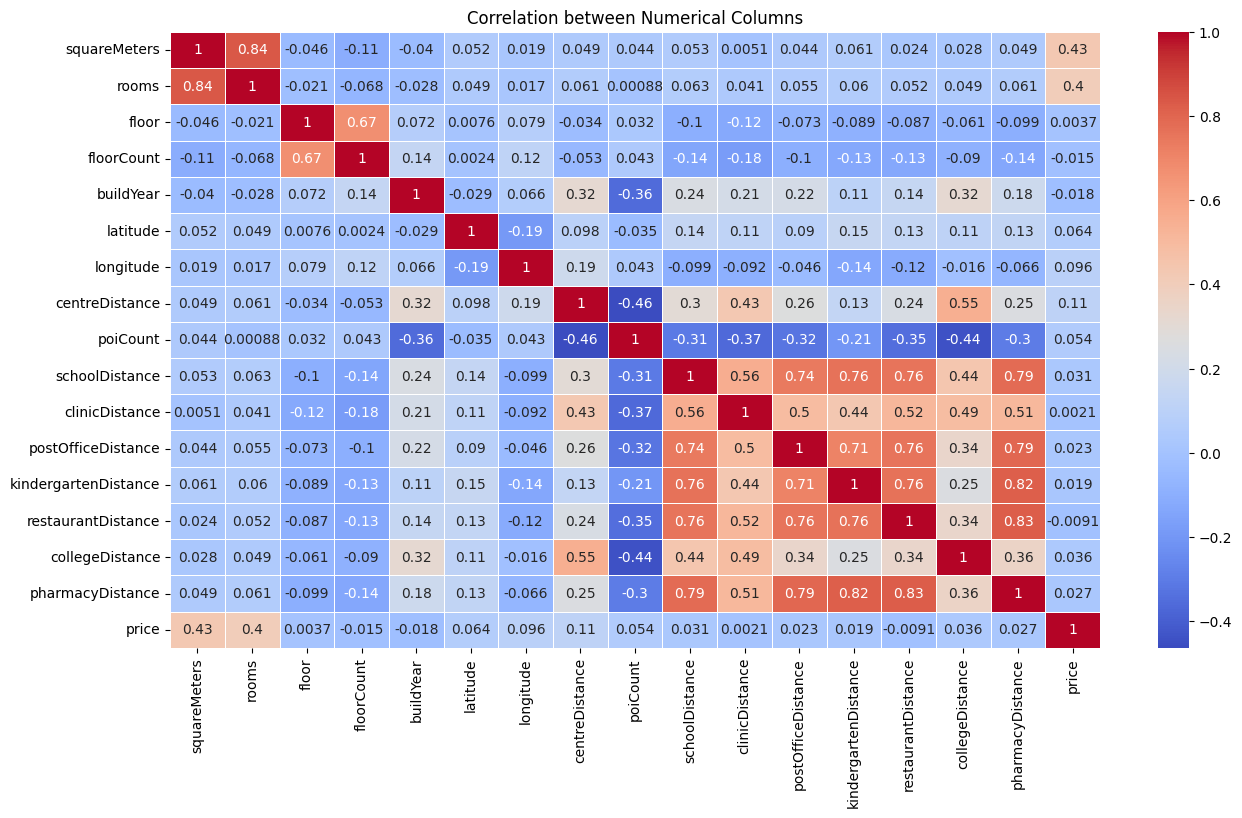

In [30]:
# Call the function to visualize correlation
visualize_correlation(all_data_df)

5. **Додатковий аналіз на основі кореляції**:
    - **`squareMeters` та `rooms` мають високу кореляцію (0.84)**. Якщо є пропуски в обох змінних, можна розглянути залежність між площею та кількістю кімнат для заповнення. Наприклад, оцінити середню площу для відповідної кількості кімнат.В нашому дата сеті, це не є необхідним, оскільки ми маємо ці дані в повному обсязі, але ми зможемо використати це в майбутньому, коли зявиться така потреба при доповненні новими даними 
    - **Кореляція між відстанями до об'єктів** (наприклад, `schoolDistance`, `kindergartenDistance`, `collegeDistance`) також висока. Це свідчить про те, що ці змінні можуть бути взаємозамінними або використовуватися одна для заповнення іншої в разі пропусків.

  EN:

5. **Additional Analysis Based on Correlation**:
   - **`squareMeters` and `rooms` have a high correlation (0.84)**. If there are missing values in both variables, we can consider the relationship between area and the number of rooms to fill in the gaps. For instance, we could estimate the average area for the corresponding number of rooms. In our dataset, this is not necessary, as we have complete data, but we may use this approach in the future if new data requires supplementation.
   - **Correlation between distances to objects** (e.g., `schoolDistance`, `kindergartenDistance`, `collegeDistance`) is also high. This indicates that these variables might be interchangeable or one could be used to fill in the missing values for another.

In [31]:
# Check the content of text columns
show_unique_values(all_data_df)

city - szczecin, gdynia, krakow, poznan, bialystok, gdansk, wroclaw, radom, rzeszow, lodz, katowice, lublin, czestochowa, warszawa, bydgoszcz
type - blockOfFlats, tenement, apartmentBuilding, nan
ownership - condominium, cooperative, udział
buildingMaterial - concreteSlab, brick, nan
condition - nan, low, premium
hasParkingSpace - yes, no
hasBalcony - yes, no
hasElevator - yes, no, nan
hasSecurity - no, yes
hasStorageRoom - yes, no


6. **Додатковий аналіз наповнення текстових стовпців**:
  Провіримо наповненість текстових стовпців, щоб зрозуміти чи всі дані є однорізними та зрозумілими до сприйняття.
    - **Стовпець `ownership`** має не зовсім зрозуміла неповнення condominium, cooperative, udział. Тобто при роботі з данми замінемо польське слово udział на англійський відповідник, оскільки вся інша інформацію представлена англійськими відповідниками 
    - **в стовпцях**, що містять дані в виді **`yes` ,`no`** для зручності аналізу ми замінимо їх на `1` та `0`

EN:

6. **Additional Analysis of Text Column Completeness**:
   Let's check the completeness of the text columns to determine if all the data is consistent and easy to understand.
   - **The `ownership` column** has some inconsistent values like "condominium," "cooperative," and "udział". Therefore, when working with the data, we will replace the Polish word "udział" with its English equivalent, as the rest of the information is represented in English.
   - **In columns** that contain data in the form of **`yes`, `no`**, for ease of analysis, we will replace them with `1` and `0`.

In [32]:
# Check for duplicate IDs
analyze_id_column(all_data_df)

Duplicates found: 135507


7.**Оцінка дублюючих даних**:
    - Ми виявили наявність дублюючих даних,при обробці дата сету важливо їх видалити, щоб не спотворювати загальну аналітичну картину

EN:


7. **Duplicate Data Evaluation**:
   - We found duplicate data. It is important to remove duplicates when processing the dataset to avoid distorting the overall analytical picture.